### Logistic Regression with PyTorch
This notebook builds a logistic regression model using Pytorch Linear layer and binary cross-entropy loss. The performance is similar to a logistic regression implementation from scikit-learn

In [182]:
from sklearn.datasets import make_classification
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

mpl.rcParams["figure.figsize"] = (6, 6)

### Making a classification dataset using `sklearn` 

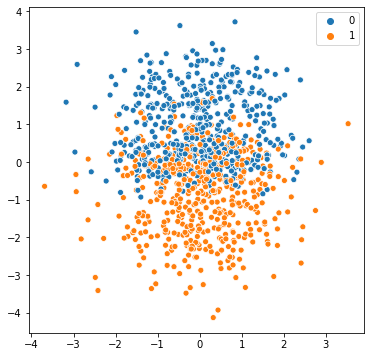

In [135]:
random_state = 42
nsamples = 1000
nfeatures = 20

X, y = make_classification(n_samples=nsamples, 
                           n_features=nfeatures, 
                           random_state=42, 
                           class_sep=2)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)

### Preparing dataset for train and validation

In [142]:
test_size = int(nsamples * 0.2)
test_idx = np.random.choice(range(nsamples), test_size, replace=False)

Xtrain, Xvalid = X[test_idx, :], X[~test_idx, :]
ytrain, yvalid = y[test_idx], y[~test_idx]

In [143]:
Xtrain_tensor = torch.tensor(Xtrain, dtype=torch.float32)
Xvalid_tensor = torch.tensor(Xvalid, dtype=torch.float32)

ytrain_tensor = torch.tensor(ytrain, dtype=torch.float32).unsqueeze(1)
yvalid_tensor = torch.tensor(yvalid, dtype=torch.float32).unsqueeze(1)

### PyTorch model

In [195]:
class TorchLogisticRegression(nn.Module):
    def __init__(self, features):
        super(TorchLogisticRegression, self).__init__()
        self.linear = nn.Linear(features, 1)
        
    def forward(self, x):
        return self.linear(x)

In [207]:
def build_model(niterations, lr=0.01):
    model = TorchLogisticRegression(nfeatures)
    loss_function = nn.BCEWithLogitsLoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    model.train()

    train_losses, valid_losses = [], []

    for _ in range(niterations):
        model.train()
        with torch.set_grad_enabled(True):
            logits = model(Xtrain_tensor)
            loss = loss_function(logits, ytrain_tensor)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_losses += [loss.item()]

        model.eval()
        with torch.set_grad_enabled(False):
            logits = model(Xvalid_tensor)
            loss = loss_function(logits, yvalid_tensor)
            valid_losses += [loss.item()]
    
    # plotting losess
    ax = sns.lineplot(list(range(len(train_losses))), train_losses)
    ax = sns.lineplot(list(range(len(valid_losses))), valid_losses)
    ax.set_title(f"Train and valid losses, learning_rate=({lr})");
            
    return model, train_losses, valid_losses

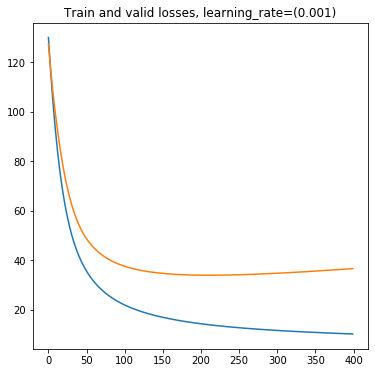

In [209]:
model, train_losses, valid_losses = build_model(400, lr=0.001)

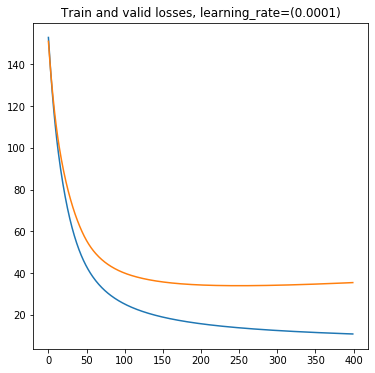

In [210]:
model, train_losses, valid_losses = build_model(400, lr=0.0001)

### Model inference

In [211]:
logits = model(Xvalid_tensor)
probs = torch.sigmoid(logits)

In [212]:
pytorch_roc = roc_auc_score(yvalid, probs.detach().numpy())

### Logistic regression using sklearn

In [213]:
lr = LogisticRegression()
lr_fit = lr.fit(Xtrain, ytrain)
sklearn_roc = roc_auc_score(yvalid, lr.predict_proba(Xvalid)[:,1])

In [214]:
print(f"ROC from sklearn model: {sklearn_roc:.4f}")
print(f"ROC from pytorch model: {pytorch_roc:.4f}")

ROC from sklearn model: 0.9784
ROC from pytorch model: 0.9780
